In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import numpy as np
import os
import re
import string
import random
import tensorflow_datasets as tfds
import pickle
from keras.layers.normalization import BatchNormalization

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers.merge import concatenate
import pickle

## sentence generator and perplexity calculator for model 1 and 2

In [5]:
def generate_sen(vocab,reverse_vocab,mdl,input_len,Start_prompt,words_to_generate=10):
  start_prompt = Start_prompt.split()
  list_tok = [reverse_vocab.get(i,1) for i in start_prompt]
  #print(" list_tok " ,list_tok)
  l = len(list_tok)

  if (l<input_len):
    list_tok = [0]*(input_len-l) + list_tok
    l = input_len

  generated_tokens = []
  for i in range(words_to_generate):
    x1 = list_tok[-input_len:]
#    print([vocab[i] for i in x1])
    x = np.array(x1)
    y_pred = mdl.predict(x)[-1].reshape(-1,)
    pred = np.argmax(y_pred)
    generated_tokens.append(pred)
    list_tok.append(pred)

  generated_string = ' '.join([vocab[i] for i in generated_tokens])
#  print(" list_tok " ,list_tok)
  return generated_string
  

In [6]:
def get_perplexity(sentence,reverse_vocab,mdl,input_len):
  list_tok = [reverse_vocab.get(i,1) for i in sentence.split()]
  l = len(list_tok)

  if(l<= input_len):
    list_tok = [0]*(input_len-l+1) + list_tok
    l = input_len+1
  y_prob = []
  for st in range(0,l-input_len):
    x = list_tok[st:st+input_len]
    x = np.array(x)
    y_softmax = mdl.predict(x)[-1].reshape(-1,)
    y_prob.append(y_softmax[list_tok[st+input_len]])

  y_prob = np.array(y_prob).astype(np.float64)
  return pow(1/np.prod(y_prob),1/l)

In [41]:
def get_perplexity1(sentence,word_to_lid,reverse_vocab,mdl,input_len):
  list_tok = [reverse_vocab.get(i,1) for i in sentence.split()]
  lid_tok = [word_to_lid.get(i,0) for i in sentence.split()]
  l = len(list_tok)

  if(l<= input_len):
    list_tok = [0]*(input_len-l+1) + list_tok
    lid_tok = [0]*(input_len-1+1) + lid_tok
    l = input_len+1
  y_prob = []
  for st in range(0,l-input_len):
    x1 = list_tok[st:st+input_len]
    x1 = np.array(x1)
    x2 = lid_tok[st:st+input_len]
    x2 = np.array(x2)
    y_softmax = mdl.predict([x1,x2])[-1].reshape(-1,)
    y_prob.append(y_softmax[list_tok[st+input_len]])

  y_prob = np.array(y_prob).astype(np.float64)
  return pow(np.float64(1/np.prod(y_prob)),np.float64(1/l))

## sentence generator and perplexity calculator for model 3 and 4

In [51]:
def generate_sen1(vocab,reverse_vocab,word_to_lid,mdl,input_len,Start_prompt,words_to_generate=10):
  start_prompt = Start_prompt.split()
  list_tok = [reverse_vocab.get(i,1) for i in start_prompt]
  lid_tok = [word_to_lid.get(i,0) for i in start_prompt] #defaulting to english
  #print(" list_tok " ,list_tok)
  #print(lid_tok,list_tok,sep='\n')
  l = len(list_tok)

  if (l<input_len):
    list_tok = [0]*(input_len-l) + list_tok
    lid_tok = [0]*(input_len-1) +lid_tok  #defaulting to english
    l = input_len

  generated_tokens = []
  for i in range(words_to_generate):
    x1 = list_tok[-input_len:]
    x2 = lid_tok[-input_len:]

    #print([vocab[i] for i in x1])
    x1 = np.array(x1)
    x2 = np.array(x2)
    #print(x1.shape,x2.shape)
    y_pred = mdl.predict([x1,x2])[-1].reshape(-1,)
    pred = np.argmax(y_pred)
    generated_tokens.append(pred)
    list_tok.append(pred)
    lid_tok.append(word_to_lid.get(pred,0)) #defaulting to english

  generated_string = ' '.join([vocab[i] for i in generated_tokens])
#  print(" list_tok " ,list_tok)
  return generated_string

In [6]:
vc = pickle.load( open( "/content/drive/MyDrive/data/vocab.pickle", "rb" ) )
ix_to_vc = pickle.load(open('/content/drive/MyDrive/data/ix_to_vocab.pickle','rb'))

In [7]:
word_to_lid = pickle.load(open('/content/drive/MyDrive/finally_final/word_to_lid.pickle','rb'))

In [11]:
print(len(vc),len(ix_to_vc),len(word_to_lid))

28232 28232 28232


In [12]:
def get_lines(file):
  f = open(file,'r')
  lines = []
  for i in f:
    lines.append(i)
  return lines

In [13]:
 train_l = get_lines('/content/drive/MyDrive/data/train_1000')

In [14]:
 test_l = get_lines('/content/drive/MyDrive/data/test_1000')

In [15]:
def evaluate(lines,reverse_vocab,mdl,input_len):
  pep = np.float64(0)
  line_no = 1
  for line in lines:
    if(line_no%10 == 0):
      print("line_no",line_no)
    try:
      pep = pep + get_perplexity(sentence=line,reverse_vocab=reverse_vocab,mdl=mdl,input_len=5)
    except:
      pep = 0
    line_no += 1
  return pep/len(lines)

In [16]:
def evaluate1(lines,reverse_vocab,word_to_lid,mdl,input_len):
  pep = np.float64(0)
  line_no = 1
  for line in lines:
    if(line_no%10 == 0):
      print("line_no",line_no)
    try:
      pep = pep + get_perplexity1(sentence=line,word_to_lid=word_to_lid,reverse_vocab=reverse_vocab,mdl=mdl,input_len=5)
    except:
      pep = 0
    line_no += 1
  return pep/len(lines)

#training perplexity score of all the models

In [17]:
avg_train_perp=[]

In [ ]:
mdl_filenames = ['/content/drive/MyDrive/finally_final/mdl_1/50/model','/content/drive/MyDrive/finally_final/mdl_2/50/model','/content/drive/MyDrive/finally_final/mdl_3/50/model','/content/drive/MyDrive/finally_final/mdl_4/40/model']
for iter in range(len(mdl_filenames)):
  print("model_no = ",iter)
  mdl = keras.models.load_model(mdl_filenames[iter])
  if(iter>1):
    pp = evaluate1(lines=train_l,reverse_vocab=ix_to_vc,word_to_lid=word_to_lid,mdl=mdl,input_len=5)
  else:
    pp = (evaluate(lines = train_l,reverse_vocab=ix_to_vc,mdl=mdl,input_len=5))
  avg_train_perp.append(pp)


In [19]:
avg_train_perp

[93.80191229524303, 88.06339426340698, 174.3293444441273, 151.77433722377782]

#testing perplexity score of all the models

In [ ]:
avg_test_perp = []
for iter in range(2,len(mdl_filenames)):
  print("model_no = ",iter)
  mdl = keras.models.load_model(mdl_filenames[iter])
  if(iter>1):
    pp = evaluate1(lines=test_l[:30],reverse_vocab=ix_to_vc,word_to_lid=word_to_lid,mdl=mdl,input_len=5)
  else:
    pp = (evaluate(lines = test_l[:30],reverse_vocab=ix_to_vc,mdl=mdl,input_len=5))
  avg_test_perp.append(pp)
  #print(evaluate(lines = train_l,reverse_vocab=ix_to_vc,mdl=mdl_1,input_len=5))

In [72]:
print(avg_test_perp)

[2640.9099103206026, 1481.1419700404547, 3002.189131095198, 2103.8761091645783]


In [35]:
ml1 = keras.models.load_model(mdl_filenames[0])
ml2 = keras.models.load_model(mdl_filenames[1])
ml3 = keras.models.load_model(mdl_filenames[2])
ml4 = keras.models.load_model(mdl_filenames[3])

#generating text from all the models

In [73]:
prompt = "ye desh ka kya haal"

In [74]:
s1 = generate_sen(vocab=vc,reverse_vocab=ix_to_vc,mdl=ml1,input_len=5,Start_prompt=prompt,words_to_generate=20)
s1

'hai . india ko bhi nahi hai . india ko bhi nahi hai . india ko bhi nahi hai .'

In [75]:
s2 = generate_sen(vocab=vc,reverse_vocab=ix_to_vc,mdl=ml2,input_len=5,Start_prompt=prompt,words_to_generate=20)
s2

'hai . or ab to kya . or ab to kya . or ab to kya . or ab to'

In [81]:
s3 = generate_sen1(vocab=vc,reverse_vocab=ix_to_vc,word_to_lid=word_to_lid,mdl=ml3,input_len=5,Start_prompt=prompt,words_to_generate=30)
s3

'hai most rejected area ki aab make no one time knowledge ko follow kariye nya nothing . khush kr to make no one time knowledge ko follow kariye nya nothing'

In [79]:
s4 = generate_sen1(vocab=vc,reverse_vocab=ix_to_vc,word_to_lid=word_to_lid,mdl=ml4,input_len=5,Start_prompt=prompt,words_to_generate=20)
s4

'rahenge jese to kya 26 seconds use bi . hollywood me ghus me ghus me ghus me ghus me ghus'

#model picture of all the models

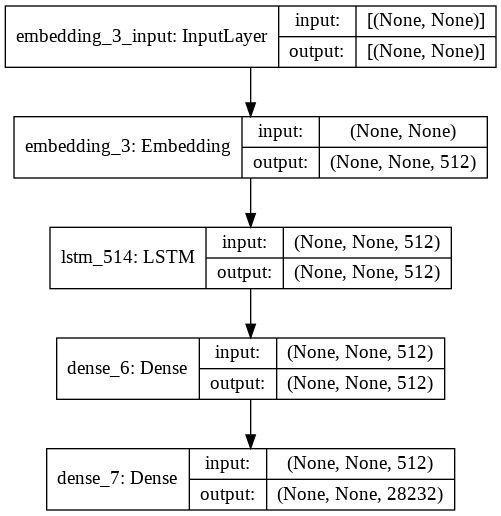

In [91]:
from keras.utils.vis_utils import plot_model
plot_model(ml1, to_file='/content/drive/MyDrive/finally_final/ml1.png', show_shapes=True, show_layer_names=True)

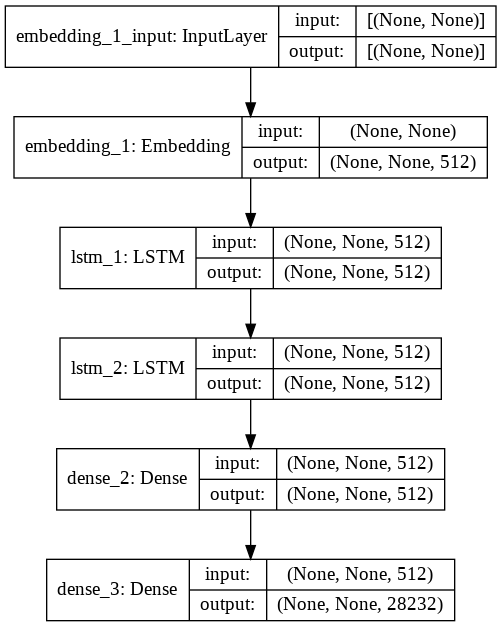

In [90]:
from keras.utils.vis_utils import plot_model
plot_model(ml2, to_file='/content/drive/MyDrive/finally_final/ml2.png', show_shapes=True, show_layer_names=True)

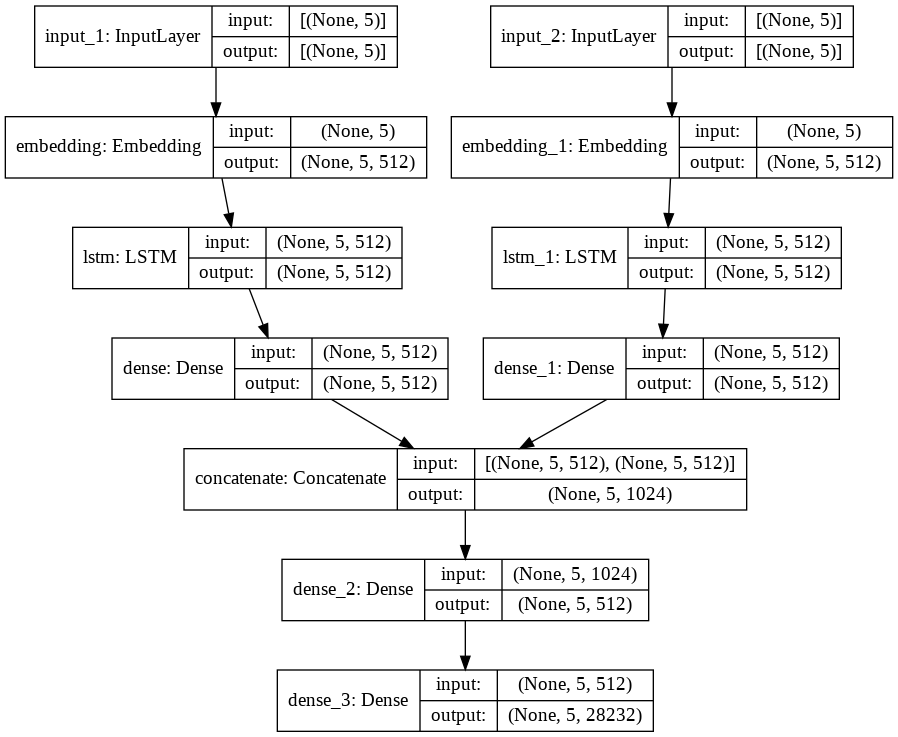

In [89]:
from keras.utils.vis_utils import plot_model
plot_model(ml3, to_file='/content/drive/MyDrive/finally_final/ml3.png', show_shapes=True, show_layer_names=True)

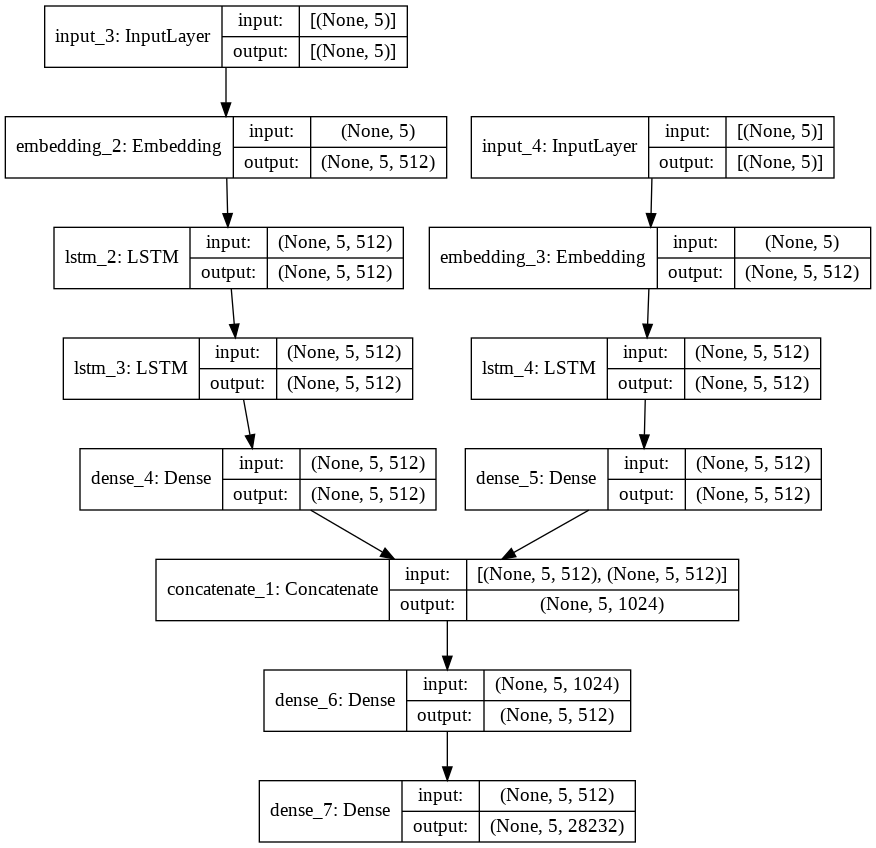

In [88]:
from keras.utils.vis_utils import plot_model
plot_model(ml4, to_file='/content/drive/MyDrive/finally_final/ml4.png', show_shapes=True, show_layer_names=True)